## General Attention Mechanism

In [55]:
from numpy import array
from numpy import random
from numpy import dot
from scipy.special import softmax
 
# encoder representations (3 dimensional) of four different words
word_1 = array([1, 0, 0])
word_2 = array([0, 1, 0])
word_3 = array([1, 1, 0])
word_4 = array([0, 0, 1])

# stacking the word embeddings into a single array
words = array([word_1, word_2, word_3, word_4])
print(words.shape)

(4, 3)


In [56]:
# generating the weight matrices
random.seed(42)
W_Q = random.randint(3, size=(3, 3))
W_K = random.randint(3, size=(3, 3))
W_V = random.randint(3, size=(3, 3))
print(W_K.shape)

(3, 3)


In [57]:
# generating the queries, keys and values
Q = words @ W_Q
K = words @ W_K
V = words @ W_V
print(Q.shape, K.shape, V.shape)

(4, 3) (4, 3) (4, 3)


In [58]:
# scoring the query vectors against all key vectors
scores = Q @ K.transpose()
print(scores.shape)

# computing the weights by a softmax operation
weights = softmax(scores / K.shape[1] ** 0.5, axis=1)
print(weights.shape)
 
# computing the attention by a weighted sum of the value vectors
attention = weights @ V
print(attention.shape)
 
print(attention)

(4, 4)
(4, 4)
(4, 3)
[[0.98522025 1.74174051 0.75652026]
 [0.90965265 1.40965265 0.5       ]
 [0.99851226 1.75849334 0.75998108]
 [0.99560386 1.90407309 0.90846923]]


## Implementing the Scaled Dot-Product Attention from Scratch in tf and keras

In [59]:
from tensorflow import matmul, math, cast, float32
from keras.layers import Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
 
    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
 
        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
 
        # Computing the weights by a softmax operation
        weights = softmax(scores)
 
        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

In [60]:
from numpy import random
 
input_seq_length = 5  # Maximum length of the input sequence
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
batch_size = 64  # Batch size from the training process
 
queries = random.random((batch_size, input_seq_length, d_k))
keys = random.random((batch_size, input_seq_length, d_k))
values = random.random((batch_size, input_seq_length, d_v))
 
attention = DotProductAttention()
print(attention(queries, keys, values, d_k).shape)

(64, 5, 64)


## Implement Multi-Head Attention from Scratch in TensorFlow and Keras

In [61]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from keras.layers import Dense, Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1)) # shape here: (batch_size, seq_length, heads, , -1)
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # print(queries.shape, self.W_q(queries).shape)
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # print(q_reshaped.shape)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        # print(keys.shape, self.W_k(keys).shape)
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # print(k_reshaped.shape)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        # print(values.shape, self.W_v(values).shape)
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # print(v_reshaped.shape)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # print(o_reshaped.shape)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # print(output.shape)
        # Resulting tensor shape: (batch_size, input_seq_length, d_k)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [62]:
from numpy import random

input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process

queries = random.random((batch_size, input_seq_length, d_k))
keys = random.random((batch_size, input_seq_length, d_k))
values = random.random((batch_size, input_seq_length, d_v))

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
multihead_attention(queries, keys, values).shape

TensorShape([64, 5, 512])

## Positional Encoding Matrix from scratch

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


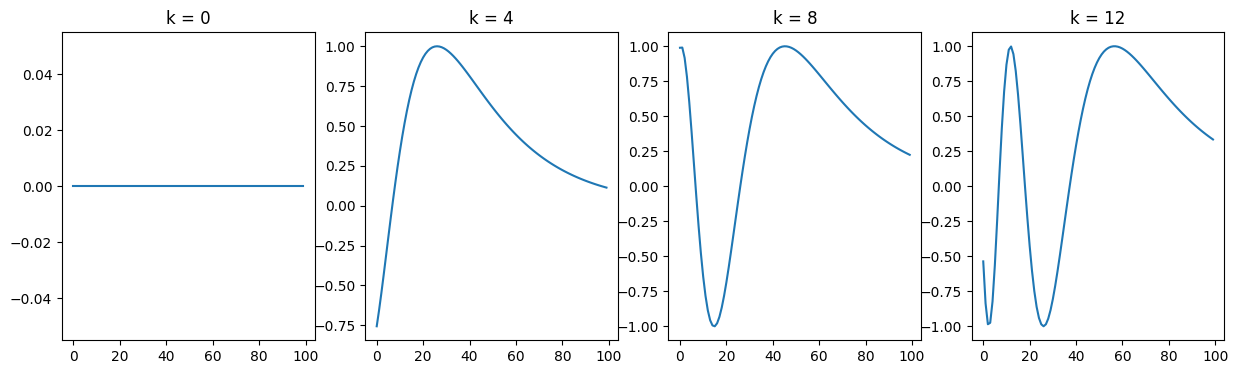

In [64]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

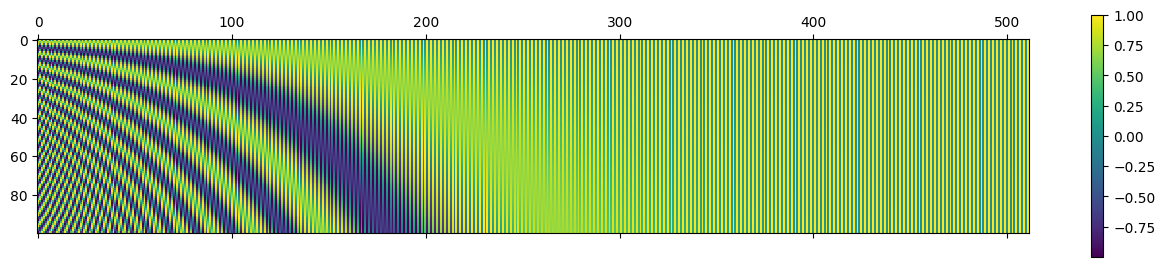

In [65]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax);

In [66]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

### Text Vectorization

In [67]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


### The Word Embeddings

In [68]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words.shape)

(2, 5, 6)


### The Position Embeddings

In [69]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices.shape)

(5, 6)


In [70]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding.shape)

Final output:  (2, 5, 6)


### SubClassing the Keras Embedding Layer

In [71]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim)
        self.position_embedding_layer = Embedding(input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        print("embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        print("embedded_indices", embedded_indices.shape)
        return embedded_words + embedded_indices

In [72]:
output_sequence_length = 5
vocab_size = 10
output_length = 6
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output.shape)

embedded_words (2, 5, 6)
embedded_indices (5, 6)
Output from my_embedded_layer:  (2, 5, 6)


### Positional Encoding in Transformers: Attention Is All You Need

In [73]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim) 
        print("word_embedding_matrix", word_embedding_matrix.shape)  
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim) 
        print("position_embedding_matrix", position_embedding_matrix.shape)                                         
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        print("embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        print("embedded_indices", embedded_indices.shape)
        return embedded_words + embedded_indices

In [74]:
output_sequence_length = 5
vocab_size = 10
output_length = 6
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length, vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output.shape)

word_embedding_matrix (10, 6)
position_embedding_matrix (5, 6)
embedded_words (2, 5, 6)
embedded_indices (5, 6)
Output from my_embedded_layer:  (2, 5, 6)


### Visualizing the Final Embedding

In [75]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
print("Vocabulary: ", phrase_vectorization_layer.get_vocabulary())
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
print("phrase_tensors", phrase_tensors)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)

print("vectorized_phrases", vectorized_phrases)

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

Vocabulary:  ['', '[UNK]', 'understand', 'to', 'of', 'me', 'give', 'a', 'you', 'when', 'virginia', 'the', 'such', 'second', 'said', 'patrick', 'or', 'optimization', 'need', 'matrix', 'march', 'machine', 'liberty', 'learning', 'in', 'hessians', 'henry', 'he', 'gradient', 'function', 'etc', 'death', 'convention', 'concepts', 'as', 'and', 'algorithms', 'addressed']
phrase_tensors tf.Tensor(
[b'to understand machine learning algorithms you need to understand concepts such as gradient of a function Hessians of a matrix and optimization etc'
 b'patrick henry said give me liberty or give me death when he addressed the second virginia convention in march'], shape=(2,), dtype=string)
vectorized_phrases tf.Tensor(
[[ 3  2 21 23 36  8 18  3  2 33 12 34 28  4  7 29 25  4  7 19]
 [15 26 14  6  5 22 16  6  5 31  9 27 37 11 13 10 32 24 20  0]], shape=(2, 20), dtype=int64)
word_embedding_matrix (200, 50)
position_embedding_matrix (20, 50)
embedded_words (2, 20, 50)
embedded_indices (20, 50)
embedded_w

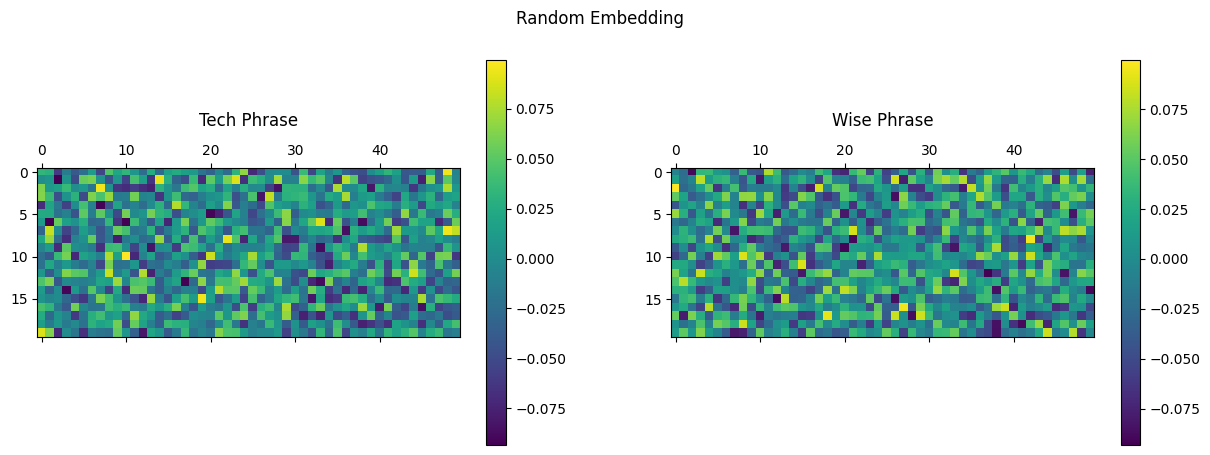

In [76]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

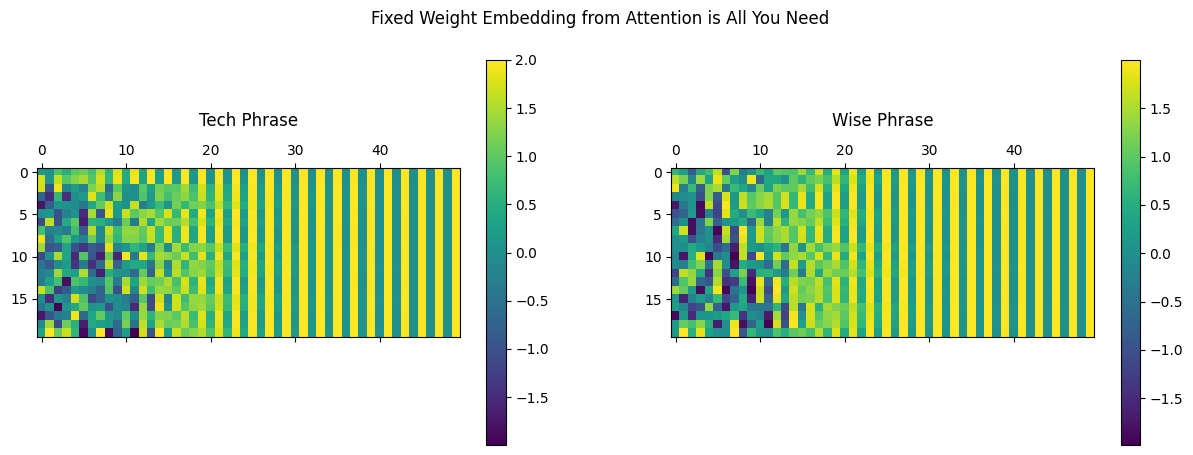

In [77]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

## Implementing the Transformer Encoder from Scratch

In [ ]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)

        return self.fully_connected2(self.activation(x_fc1))
    
# Implementing the Postional encoding Layer
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim) 
        print("word_embedding_matrix", word_embedding_matrix.shape)  
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim) 
        print("position_embedding_matrix", position_embedding_matrix.shape)                                         
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        print("embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        print("embedded_indices", embedded_indices.shape)
        return embedded_words + embedded_indices

# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

# Implementing the Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)

        return x